# process_fgmax

Read in fgmax results and produce plots.

In [1]:
%matplotlib inline

In [2]:
from pylab import *

In [3]:
import os,sys
import glob
from importlib import reload
from clawpack.geoclaw import topotools, dtopotools
from clawpack.visclaw import colormaps
from scipy.interpolate import RegularGridInterpolator
import matplotlib as mpl
from matplotlib import colors

#from clawpack.visclaw.plottools import pcolorcells # to appear in 5.7.0
from matplotlib.pyplot import pcolormesh as pcolorcells # for now

In [4]:
from clawpack.geoclaw import fgmax_tools
#sys.path.insert(0,'../../new_python')
#sys.path.insert(0,'/Users/rjl/git/clawpack/new_features_for_v5.7.0/new_python')
#import fgmax_tools

In [5]:
save_figs = True
fgmax_plotdir = '_plots/fgmax_plots'

In [6]:
os.system('mkdir -p %s' % fgmax_plotdir)
def savefigp(fname):
    global save_figs
    if save_figs:
        fullname = '%s/%s' % (fgmax_plotdir, fname)
        savefig(fullname)
        print('Created ', fullname)
    else:
        print('save_figs = False')

In [7]:
outdir = '_output'
t_files = glob.glob(outdir + '/fort.t0*')
times = []
for f in t_files:
    lines = open(f,'r').readlines()
    for line in lines:
        if 'time' in line: 
            t = float(line.split()[0])
    times.append(t)
times.sort()
print('Output times found: ',times)
if len(times) > 0:
    t_hours = times[-1] / 3600.
    print('\nfgmax results are presumably from final time: %.1f seconds = %.2f hours'\
          % (times[-1], t_hours))
else:
    t_hours = nan

Output times found:  [0.0, 1800.0, 3600.0, 5400.0, 7200.0, 9000.0, 10800.0, 12600.0, 14400.0]

fgmax results are presumably from final time: 14400.0 seconds = 4.00 hours


In [8]:
# Read fgmax data:
fgno = 1
fg = fgmax_tools.FGmaxGrid()
fg.read_fgmax_grids_data(fgno)

fg.read_output(outdir=outdir)

Reading input for fgno=1, point_style = 2 
Reading _output/fgmax0001.txt ...


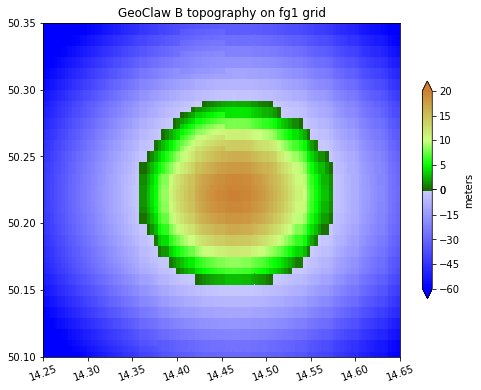

In [9]:
zmin = -60.
zmax = 20.
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

sea_cmap = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)                                   



figure(figsize=(8,8))
pc = pcolorcells(fg.X, fg.Y, fg.B, cmap=cmap, norm=norm)  

cb = colorbar(pc,shrink=0.5,extend='both')
cb.set_label('meters')
cb.set_ticks(hstack((linspace(zmin,0,5), linspace(0,zmax,5))))

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20);
    
title('GeoClaw B topography on fg1 grid');

In [10]:
fg.B0 = fg.B  # no seafloor deformation in this problem
fg.h_onshore = ma.masked_where(fg.B0 < 0., fg.h)

Created  _plots/fgmax_plots/fgmax0001_h_onshore.png


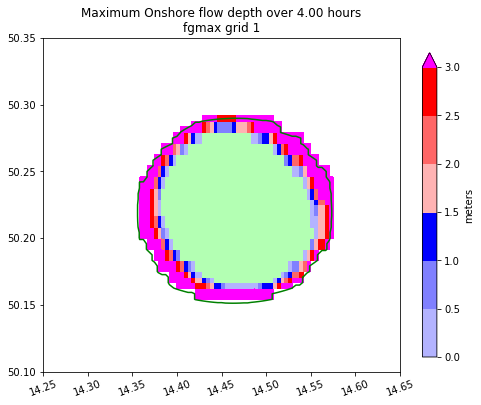

In [11]:
bounds_depth = array([1e-6,0.5,1.0,1.5,2,2.5,3.0])


cmap_depth = colors.ListedColormap([[.7,.7,1],[.5,.5,1],[0,0,1],\
                 [1,.7,.7], [1,.4,.4], [1,0,0]])

# Set color for value exceeding top of range to purple:
cmap_depth.set_over(color=[1,0,1])

# Set color for land points without inundation to light green:
cmap_depth.set_under(color=[.7,1,.7])

norm_depth = colors.BoundaryNorm(bounds_depth, cmap_depth.N)
    

figure(figsize=(8,8))
pc = pcolorcells(fg.X, fg.Y, fg.h_onshore, cmap=cmap_depth, norm=norm_depth)
cb = colorbar(pc, extend='max', shrink=0.7)
cb.set_label('meters')
contour(fg.X, fg.Y, fg.B, [0], colors='g')

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20)
title('Maximum Onshore flow depth over %.2f hours\nfgmax grid %s' % (t_hours,fgno))
savefigp('fgmax%s_h_onshore.png' % str(fgno).zfill(4))

Created  _plots/fgmax_plots/fgmax0001_speed.png


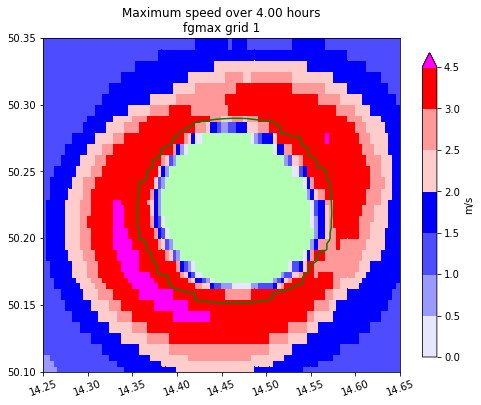

In [12]:
bounds_speed = np.array([1e-6,0.5,1.0,1.5,2,2.5,3,4.5,6])
cmap_speed = mpl.colors.ListedColormap([[.9,.9,1],[.6,.6,1],\
                 [.3,.3,1],[0,0,1], [1,.8,.8],\
                 [1,.6,.6], [1,.3,.3], [1,0,0]])


bounds_speed = np.array([1e-6,0.5,1.0,1.5,2,2.5,3,4.5])
cmap_speed = mpl.colors.ListedColormap([[.9,.9,1],[.6,.6,1],\
                 [.3,.3,1],[0,0,1], [1,.8,.8],\
                 [1,.6,.6], [1,0,0]])

# Set color for value exceeding top of range to purple:
cmap_speed.set_over(color=[1,0,1])

# Set color for land points without inundation to light green:
cmap_speed.set_under(color=[.7,1,.7])

norm_speed = colors.BoundaryNorm(bounds_speed, cmap_speed.N)

figure(figsize=(8,8))
pc = pcolorcells(fg.X, fg.Y, fg.s, cmap=cmap_speed, norm=norm_speed)
cb = colorbar(pc, extend='max', shrink=0.7)
cb.set_label('m/s')
contour(fg.X, fg.Y, fg.B0, [0], colors='g')

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20)
title('Maximum speed over %.2f hours\nfgmax grid %s' % (t_hours,fgno))
savefigp('fgmax%s_speed.png' % str(fgno).zfill(4))

Save this so we can plot the topo below...

In [13]:
import copy
fg1 = copy.copy(fg)

## Read fgmax values specified on a Transect

In [14]:
# Read fgmax data:
fgno = 2
fg = fgmax_tools.FGmaxGrid()
fg.read_fgmax_grids_data(fgno)
fg.read_output(outdir=outdir)
xx = fg.X
yy = fg.Y

Reading input for fgno=2, point_style = 1 
Reading _output/fgmax0002.txt ...


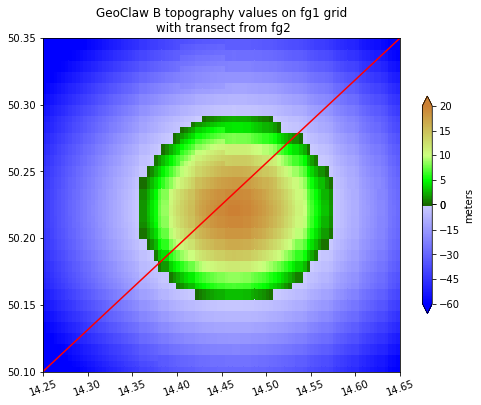

In [15]:
figure(figsize=(8,8))
pc = pcolorcells(fg1.X, fg1.Y, fg1.B, cmap=cmap, norm=norm)  

cb = colorbar(pc,shrink=0.5,extend='both')
cb.set_label('meters')
cb.set_ticks(hstack((linspace(zmin,0,5), linspace(0,zmax,5))))

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20);
    
plot(xx,yy,'r')
title('GeoClaw B topography values on fg1 grid\n with transect from fg2');

Created  _plots/fgmax_plots/fgmax0002_surface.png


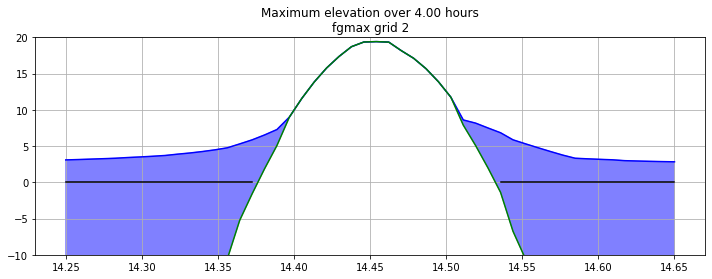

In [16]:
figure(figsize=(12,4))
fill_between(xx, fg.B, fg.B+fg.h, color=[.5,.5,1])
plot(xx,fg.B+fg.h,'b')
plot(xx,fg.B,'g')
plot(xx, ma.masked_where(fg.B>0, 0*xx), 'k')
grid(True)
ylim(-10,20);
title('Maximum elevation over %.2f hours\nfgmax grid %s' % (t_hours,fgno))
savefigp('fgmax%s_surface.png' % str(fgno).zfill(4));

## Read fgmax points as specified on a masked grid

In [17]:
fgno = 3
fg = fgmax_tools.FGmaxGrid()
fg.read_fgmax_grids_data(fgno)

fg.read_output(outdir=outdir)

Reading input for fgno=3, point_style = 4 
Reading _output/fgmax0003.txt ...
point_style == 4, found 1693 points 
Will map fgmax points onto masked arrays defined by file:
     /Users/rjl/git/clawpack/new_features_for_v5.7.0/examples/geoclaw_fgmax_test/fgmax_pts_island.data
Deduced dx = 0.005, dy = 0.005
converted level to 2d array
converted B to 2d array
converted h to 2d array
converted h_time to 2d array
converted s to 2d array
converted s_time to 2d array
not converting attribute hs == None
not converting attribute hs_time == None
not converting attribute hss == None
not converting attribute hss_time == None
not converting attribute hmin == None
not converting attribute hmin_time == None
converted arrival_time to 2d array


In [18]:
fg.B0 = fg.B  # no seafloor deformation in this problem
fg.h_onshore = ma.masked_where(fg.B0 < 0., fg.h)

/Users/rjl/miniconda/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0.5, 1.0, 'GeoClaw B at points selected as fgmax grid\nfgmax grid 3')

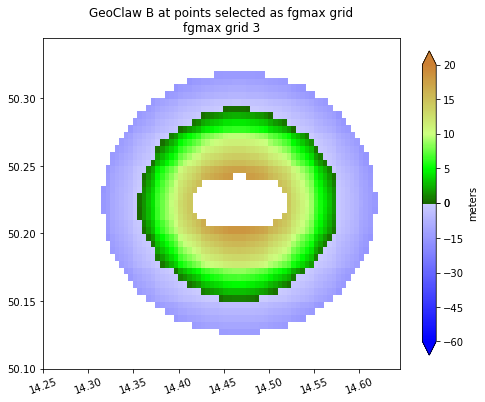

In [19]:
figure(figsize=(8,8))
pc = pcolorcells(fg.X, fg.Y, fg.B, cmap=cmap, norm=norm)
cb = colorbar(pc, extend='both', shrink=0.7)
cb.set_label('meters')
cb.set_ticks(hstack((linspace(zmin,0,5), linspace(0,zmax,5))))

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20)
title('GeoClaw B at points selected as fgmax grid\nfgmax grid %s' % fgno)

Created  _plots/fgmax_plots/fgmax0003_h_onshore.png


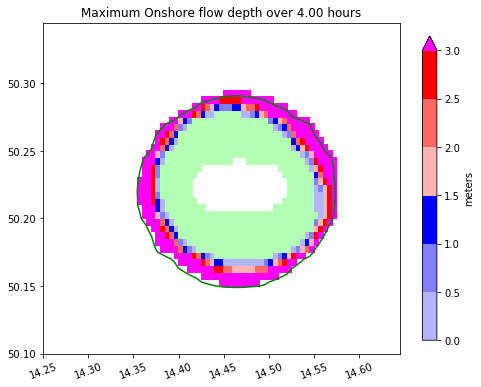

In [20]:
figure(figsize=(8,8))
pc = pcolorcells(fg.X, fg.Y, fg.h_onshore, cmap=cmap_depth, norm=norm_depth)
cb = colorbar(pc, extend='max', shrink=0.7)
cb.set_label('meters')
contour(fg.X, fg.Y, fg.B0, [0], colors='g')

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20)
title('Maximum Onshore flow depth over %.2f hours' % t_hours);
savefigp('fgmax%s_h_onshore.png' % str(fgno).zfill(4))

Created  _plots/fgmax_plots/fgmax0003_speed.png


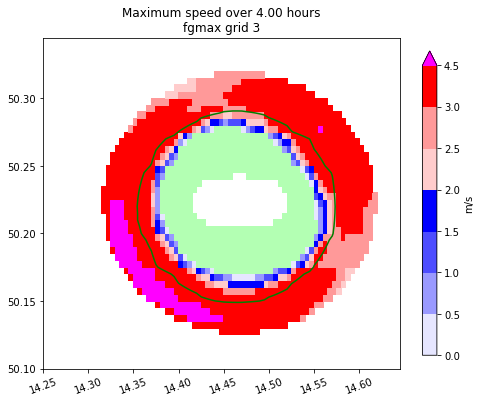

In [21]:
figure(figsize=(8,8))
pc = pcolorcells(fg.X, fg.Y, fg.s, cmap=cmap_speed, norm=norm_speed)
cb = colorbar(pc, extend='max', shrink=0.7)
cb.set_label('m/s')
contour(fg.X, fg.Y, fg.B0, [0], colors='g')

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20)
title('Maximum speed over %.2f hours\nfgmax grid %s' % (t_hours,fgno))
savefigp('fgmax%s_speed.png' % str(fgno).zfill(4))

### View fgmax points selected

This isn't generally needed, but if you want to inspect the file that specified fgmax points originally:

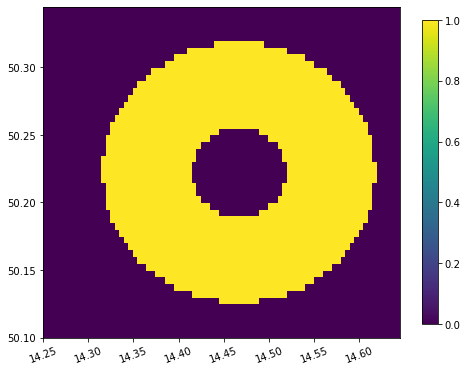

In [22]:
fg3input = topotools.Topography(path=fg.xy_fname, topo_type=3)
fg3input.X.shape

figure(figsize=(8,8))
pc = pcolorcells(fg3input.X, fg3input.Y, fg3input.Z)
cb = colorbar(pc, shrink=0.7)

gca().set_aspect(1./cos(48*pi/180.))
ticklabel_format(useOffset=False)
xticks(rotation=20);

## Read points with `point_style == 0`

In [23]:
reload(fgmax_tools)

<module 'clawpack.geoclaw.fgmax_tools' from '/Users/rjl/git/BellinghamBayMaritime/clawpack/geoclaw/src/python/geoclaw/fgmax_tools.py'>

In [24]:
# Read fgmax data:
fg = fgmax_tools.FGmaxGrid()
fg.read_fgmax_grids_data(4)

fg.read_output(outdir=outdir)
print('\n      x          y       max depth')
for j in range(fg.npts):
    print('%10.3f %10.3f %10.3f'  % (fg.X[j], fg.Y[j], fg.h[j]))

Reading input for fgno=4, point_style = 0 
Reading _output/fgmax0004.txt ...

      x          y       max depth
    14.400     50.130     20.749
    14.500     50.130     16.151


In [25]:
# Read fgmax data:
fg = fgmax_tools.FGmaxGrid()
fg.read_fgmax_grids_data(5)

fg.read_output(outdir=outdir)
print('\n      x          y       max speed')
for j in range(fg.npts):
    print('%10.3f %10.3f %10.3f'  % (fg.X[j], fg.Y[j], fg.s[j]))

Reading input for fgno=5, point_style = 0 
Read 3 x,y points from 
    /Users/rjl/git/clawpack/new_features_for_v5.7.0/examples/geoclaw_fgmax_test/fgmax_points_list.data
Reading _output/fgmax0005.txt ...

      x          y       max speed
    14.300     50.300      1.436
    14.400     50.300      2.872
    14.500     50.300      3.921
